<a href="https://colab.research.google.com/github/roboGOD/iisc-dsp-stock-price-prediction/blob/main/src/03-model-training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd

df_merged = pd.read_csv('eda.csv', index_col=0)
df_numeric = pd.read_csv('numeric_data.csv', index_col=0)
df_pca = pd.read_csv('pca_data.csv', index_col=0)

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 883 entries, 0 to 882
Columns: 116 entries, date to cumulative_profit
dtypes: float64(113), object(3)
memory usage: 807.1+ KB


In [8]:
df_merged.head()

,date,adj_close,close,high,low,open,volume,ticker,revenues,cost_of_goods,...,normalized_close,normalized_net_income,30_DMA,10_Day_Avg,Next_10_Day_Avg,signal,stock_quantity,total_buy_price,stock_profit,cumulative_profit
0,2010-04-01,7.108997,8.427500,8.526071,8.312500,8.478929,603145200.0,AAPL,13499000.0,7874000.0,...,0.000236,0.0,8.427500,NaN,8.668214,BUY,1.0,8.427500,0.0,0.0
1,2010-04-05,7.184915,8.517500,8.518214,8.384643,8.392143,684507600.0,AAPL,13499000.0,7874000.0,...,0.005641,0.0,8.472500,NaN,8.698857,BUY,2.0,16.945000,0.0,0.0
2,2010-04-06,7.216546,8.555000,8.580000,8.464286,8.507143,447017200.0,AAPL,13499000.0,7874000.0,...,0.007893,0.0,8.500000,NaN,8.716893,BUY,3.0,25.500000,0.0,0.0
3,2010-04-07,7.248483,8.592857,8.640000,8.523571,8.555357,628502000.0,AAPL,13499000.0,7874000.0,...,0.010166,0.0,8.523214,NaN,8.783393,BUY,4.0,34.092857,0.0,0.0
4,2010-04-08,7.228898,8.569643,8.626429,8.501429,8.587143,572989200.0,AAPL,13499000.0,7874000.0,...,0.008772,0.0,8.532500,NaN,8.878107,BUY,5.0,42.662500,0.0,0.0


In [10]:
df_merged['signal'] = df_merged['signal'].map({'BUY': 1, 'SELL': 0})

## LSTM Model (with just Close price)

### Prepare the model

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Prepare the data
df = df_merged[['close', 'signal']]

# Feature scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Split into training and testing sets
X = []
y = []
for i in range(60, len(df)):  # Use 60 previous time steps as input
    X.append(scaled_data[i-60:i, 0])  # Consider only the 'close' price for now
    y.append(scaled_data[i, 1])  # Predict the signal

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32) # Adjust epochs and batch_size


# Evaluate the model
loss = model.evaluate(X_test, y_test)
print('Test Loss:', loss)

predictions = model.predict(X_test)

predictions = (predictions > 0.5).astype(int)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.3880
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.2804
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.2516
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.2505
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.2451
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.2417
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.2413
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.2437
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.2442
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.2442
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2471
Test Loss: 0.24656493961811066
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


### Model Evaluation (LSTM)

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

Precision: 0.5714285714285714
Recall: 0.6593406593406593
F1-score: 0.6122448979591837
Confusion Matrix:
[[29 45]
 [31 60]]


In [15]:
class_report = classification_report(y_test, predictions, output_dict=True)
df_class_report = pd.DataFrame(class_report).transpose()
df_class_report

,precision,recall,f1-score,support
0.0,0.483333,0.391892,0.432836,74.000000
1.0,0.571429,0.659341,0.612245,91.000000
accuracy,0.539394,0.539394,0.539394,0.539394
macro avg,0.527381,0.525616,0.522540,165.000000
weighted avg,0.531919,0.539394,0.531783,165.000000


## SARIMAX Model (with just Close price)

In [18]:
df_numeric['signal'] = df_merged['signal']

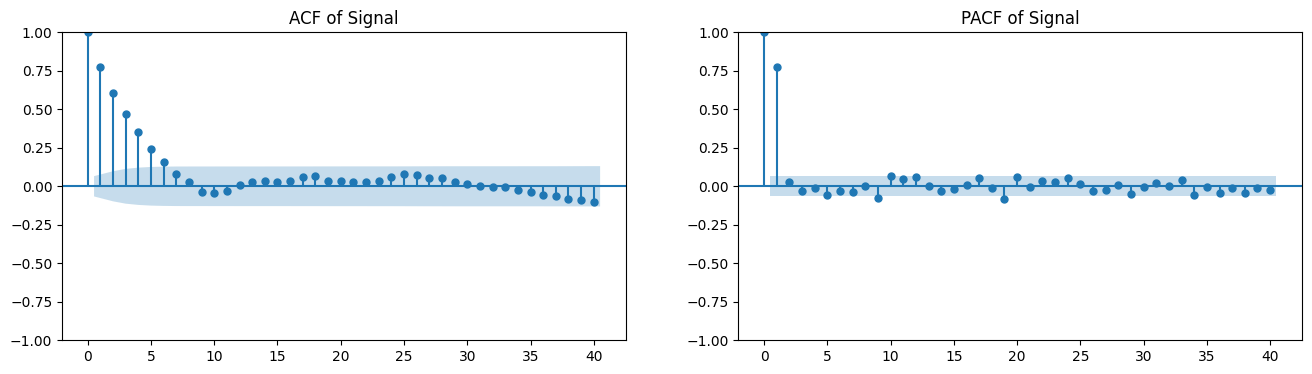

In [20]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the 'signal' column
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(df_numeric['signal'], ax=axes[0], lags=40)  # Adjust lags as needed
axes[0].set_title('ACF of Signal')

# PACF plot
plot_pacf(df_numeric['signal'], ax=axes[1], lags=40) # Adjust lags as needed
axes[1].set_title('PACF of Signal')

plt.show()


# Based on the ACF and PACF plots, determine (p, d, q) values:
# p: The lag value where PACF cuts off (or near zero)
# d: The degree of differencing needed for stationarity
# q: The lag value where ACF cuts off (or near zero)
# This is a visual inspection. It may require experimentation to find the best (p,d,q) combination.
# Example: If PACF cuts off at lag 2 and ACF cuts off at lag 1, and the data is stationary, then (p, d, q) might be (2, 0, 1)


In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Split data into training and testing sets (Time Series Split)
train_size = int(len(df_numeric) * 0.8)
train_data, test_data = df_numeric[:train_size], df_numeric[train_size:]

# Fit SARIMAX model
# Replace (p, d, q), (P, D, Q), and s with appropriate values based on your ACF and PACF plots
# and data characteristics.
model = SARIMAX(train_data['signal'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
model_fit = model.fit(disp=False)

# Make predictions
predictions = model_fit.predict(start=len(train_data), end=len(df_numeric)-1)

### Model Evaluation (SARIMAX)

In [24]:
predictions = (predictions > 0.5).astype(int)

# Calculate precision, recall, and F1-score
precision = precision_score(test_data['signal'], predictions)
recall = recall_score(test_data['signal'], predictions)
f1 = f1_score(test_data['signal'], predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(test_data['signal'], predictions)
print("Confusion Matrix:")
print(conf_matrix)

Precision: 0.40963855421686746
Recall: 0.3953488372093023
F1-score: 0.40236686390532544
Confusion Matrix:
[[42 49]
 [52 34]]
